# Downloading the data

In [9]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('../data/steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Carga de datos and y configuracion de los graficos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
fname = []
for j in range(3):
  fname.append('../data/steinmetz_part%d.npz'%j)
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('../data/steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
  
# @title Figure settings
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Extraccion y restructuracion de datos relevantes

In [2]:

# session 35 neuron x trial x activation
data = alldat[35]['spks']
print(data.shape) # no puedo usar PCA es tridimensional, neurona x trial x activation

# agrupo por slots de tiempo
window_size = 10
stride = 1

num_windows = (data.shape[2] - window_size) // stride + 1

windowed_data = []

for i in range(num_windows):
    window_data = data[:, :, i * stride:i * stride + window_size]
    window_avg = np.mean(window_data, axis=2)
    windowed_data.append(window_avg)

data_avg = np.stack(windowed_data, axis=2)
print(data_avg.shape)
flattened_data = data_avg.reshape(data_avg.shape[0], -1)
print(flattened_data.shape)

(680, 258, 250)
(680, 258, 241)
(680, 62178)


# PCA

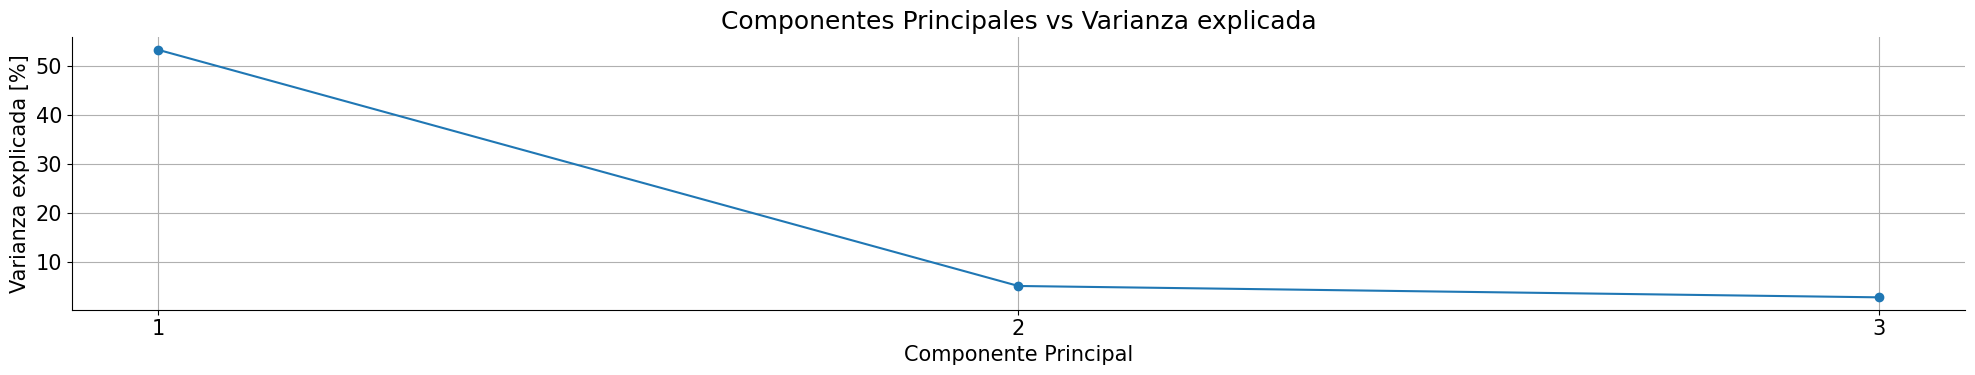

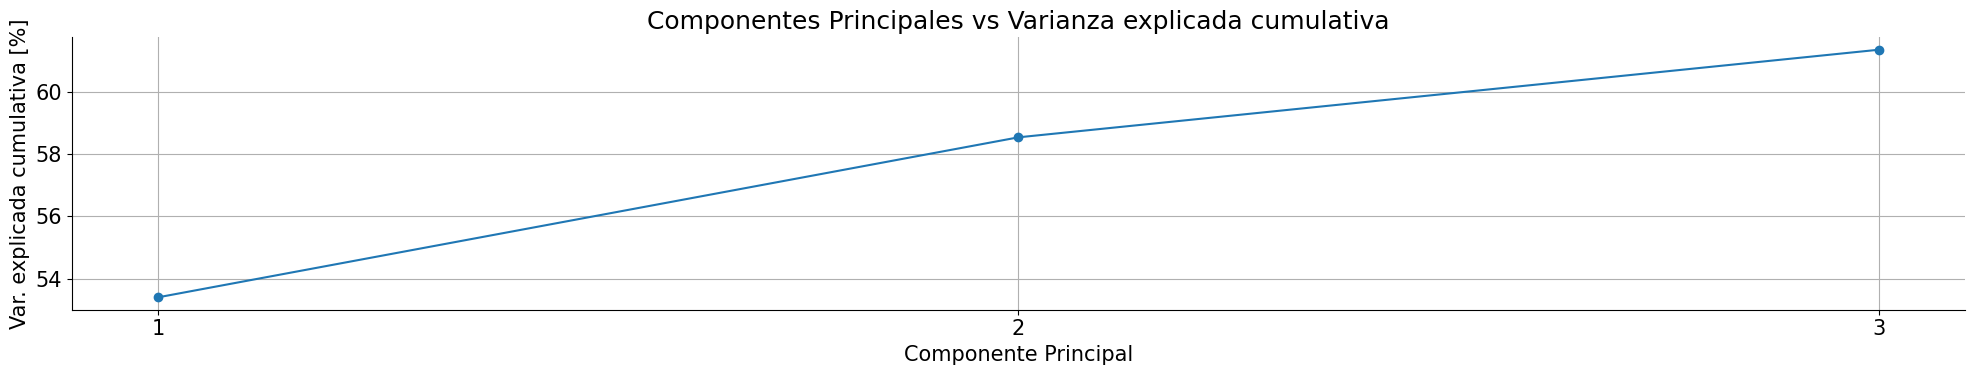

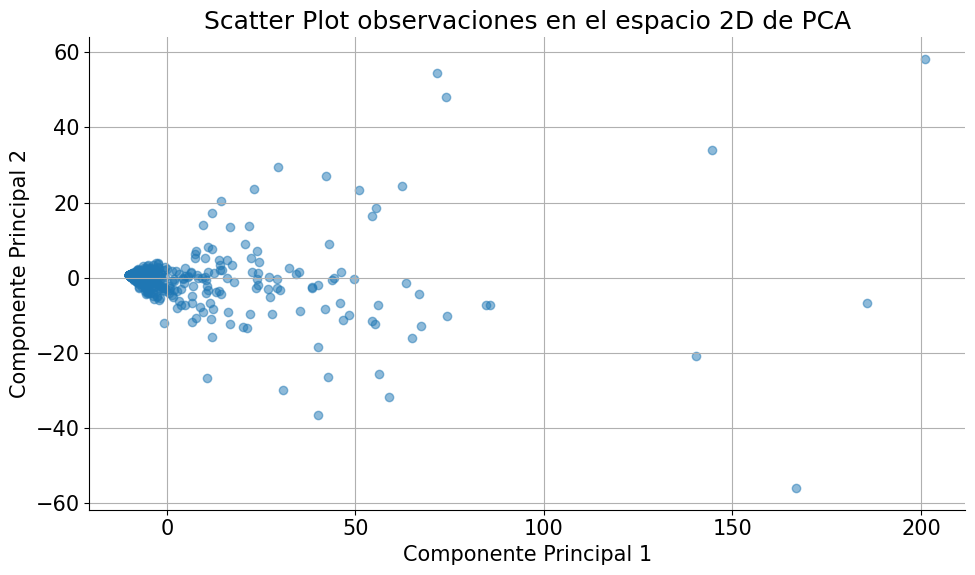

In [3]:

# 3 componentes
pca = PCA(3)
# mouse 1
pca_results = pca.fit_transform(flattened_data)
# Explained variance vs Principal component
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance*100, marker='o')
plt.xticks(range(1, len(explained_variance) +1))
plt.xlabel("Componente Principal")
plt.ylabel("Varianza explicada [%]")
plt.title("Componentes Principales vs Varianza explicada")
plt.grid(True)
plt.show()


cumulative_variance = np.zeros(explained_variance.shape)
for i in range(len(explained_variance)):
    for j in range(0, i+1):
        cumulative_variance[i] += explained_variance[j]

# Cumulative variance vs Principal component
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance*100, marker='o')
plt.xticks(range(1, len(cumulative_variance) +1))
plt.xlabel("Componente Principal")
plt.ylabel("Var. explicada cumulativa [%]")
plt.title("Componentes Principales vs Varianza explicada cumulativa")
plt.grid(True)
plt.show()

# 10 colores
# colores = [(i // (len(pca_results)//5)) + 1 for i in range(len(pca_results))]

# PC1 vs. PC2
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0],  # PCA1
            pca_results[:, 1],  # PCA2 
            alpha=0.5,          # Transparencia 
            #c=colores          # asignacion de colores
            )          

plt.title('Scatter Plot observaciones en el espacio 2D de PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()



##### La varianza cumulativa para PCA1 + PCA2 da al rededor de 58-59%, por lo tanto podemos decir que nos da un calor significativo. Al hacer el grafico PCA1 vs PCA2 se ve claramete que hay un cluster de puntos cerca del origen, el cual luego se dispersa en forma conica orientada de forma positiva en el eje x.

#### El hecho de que muchos puntos se agrupan en el 0, 0 me hace pensar que las neuronas no estan disparando la mayor parte del tiempo, quizas porque no filtre el inicio del experimento y el raton esta en "idle"

# TSNE

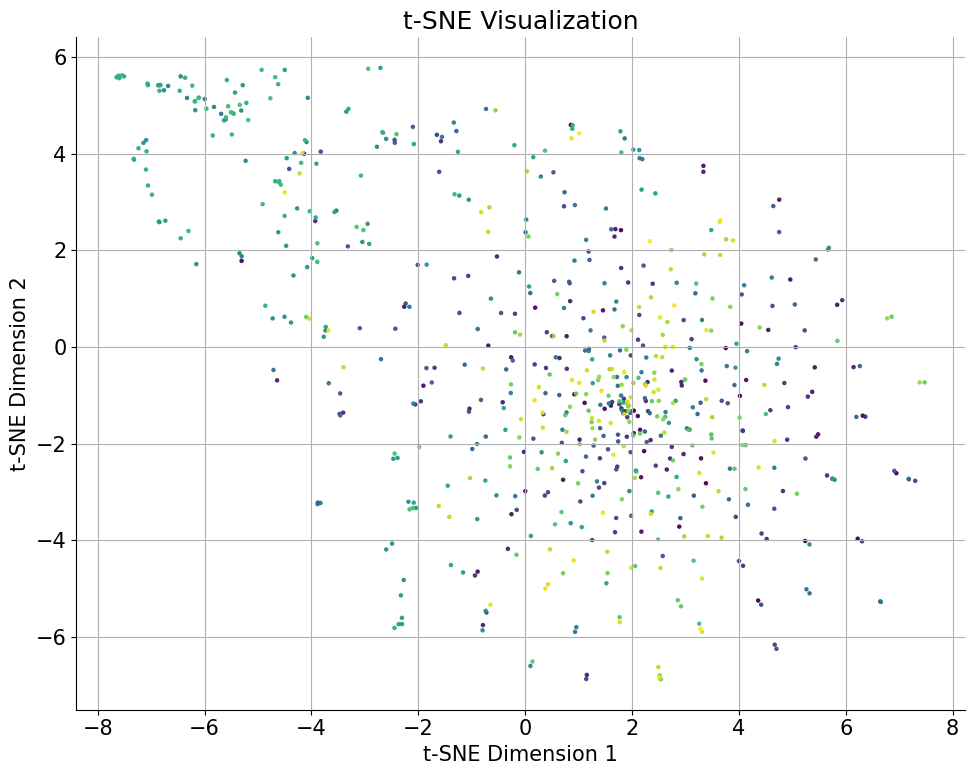

In [4]:
from sklearn.manifold import TSNE

# random_state fijo me va a dar siempre el mismo grafico
# perplexity es el numero de vecinos a considerar durante la optimizacion
tsne = TSNE(n_components=2, perplexity=20, random_state=9)
tsne_results = tsne.fit_transform(flattened_data)

colores = [(i // 25) + 1 for i in range(len(tsne_results))]


plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, c=colores, alpha=0.9)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

#### Al realizar el grafico de TSNE utilice un random state fijo, con intension de que correr multiples veces el bloque de codigo no produzca resultados distintos. De todas formas previo a esto probe ejecutar el bloque retiradas veces y siempre da una forma parecida. La misma tendia a ser continuamente algo simil a un conjunto de anillos concentricos, con una desviacion en una seccion del mismo. En este cado podemos ver como el centro estaria cerca del punto (2, -1) y se percibe una desviacion de los datos en la esquina superior izquierda. Podriamos pensar que estos circulos representan algun tipo de estructura, pero al colorearlos segun el orden post ejecucion de fit-transform vemos que los mismos estan bastante dispersos. Por lo que no me animaria a sacar conclusiones

# UMAP

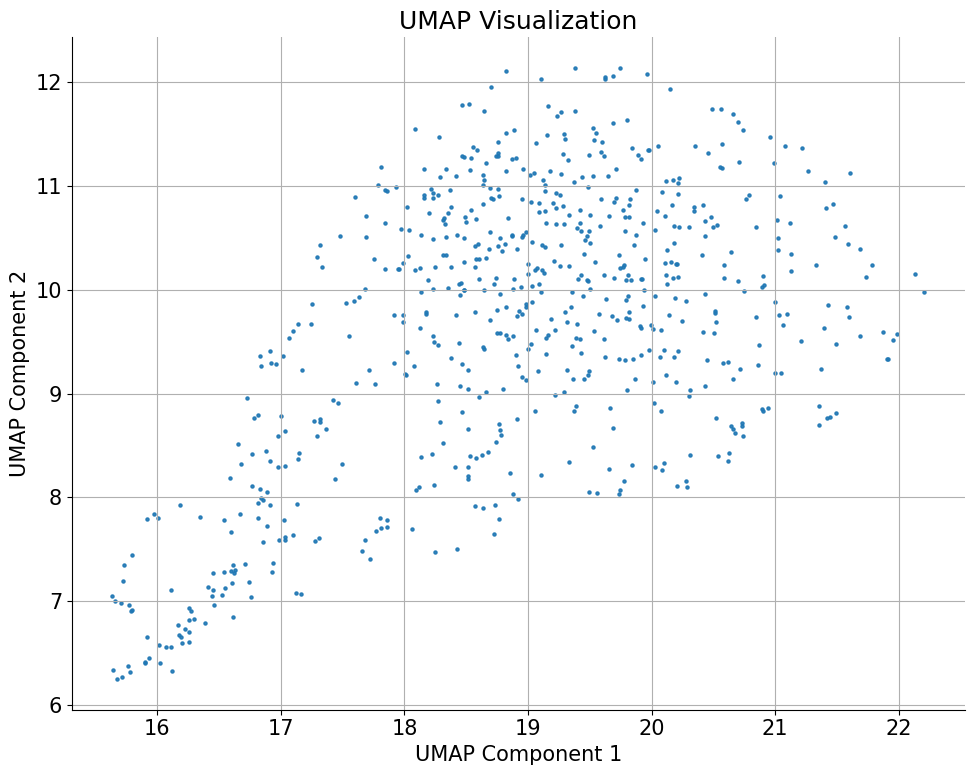

In [14]:
from umap import UMAP

umap_ = UMAP()
umap_results = umap_.fit_transform(flattened_data)

plt.figure(figsize=(10, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=5, alpha=0.9)
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

#### Al igual que tsne, umap tiene parte probabilistica por lo que cada ejecucion de distinto. Aun asi en las varias ejecuciones que realice, el resultado es siempre similar, una nube de puntos sin una relacion clara, similar a la nube del tsne, pero sin una forma circular tan marcada.